# This jupyter notebook is a showcase in time-series data prediction by using machine learning. 

In this notebook I would show how to build a preliminary LSTM neural network for predicting individual household eletric power consumption. I would use the dataset from UCI Machine Lerning Repository, which can be found through this link http://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption.

# Description of Data

## Data Set Information：
This archive contains 2075259 measurements gathered between December 2006 and November 2010 (47 months).   
Notes: 
1. (global_active_power*1000/60 - sub_metering_1 - sub_metering_2 - sub_metering_3) represents the active energy consumed every minute (in watt hour) in the household by electrical equipment not measured in sub-meterings 1, 2 and 3. 
2. The dataset contains some missing values in the measurements (nearly 1,25% of the rows). All calendar timestamps are present in the dataset but for some timestamps, the measurement values are missing: a missing value is represented by the absence of value between two consecutive semi-colon attribute separators. For instance, the dataset shows missing values on April 28, 2007.

## Attribute Information:
1. date: Date in format dd/mm/yyyy   
2. time: time in format hh:mm:ss   
3. global_active_power: household global minute-averaged active power (in kilowatt)   
4. global_reactive_power: household global minute-averaged reactive power (in kilowatt)   
5. voltage: minute-averaged voltage (in volt)   
6. global_intensity: household global minute-averaged current intensity (in ampere)   
7. sub_metering_1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).   
8. sub_metering_2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.   
9. sub_metering_3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.  

# Import necessary libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt # this is used for the plot the graph 
import seaborn as sns # used for plot interactive graph. 
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics 
from sklearn.metrics import mean_squared_error

## for Deep-learing:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout


%matplotlib inline
plt.style.use('ggplot')

Using TensorFlow backend.


# Import data and data preprocessing

In [2]:
## Import data
df = pd.read_csv('household_power_consumption.txt',sep=';',parse_dates={'dt':['Date','Time']},index_col='dt',
                 infer_datetime_format=True,na_values=['nan','?'])

<font color='red'>
1. I want to use datetime as index of the dataset, so I merged columns 'Date' and 'Time' to 'dt' and set 'dt' as index column.  
2. As the description said, na values are represented in string value, I converted to numpy nan values. </font>

In [3]:
## Get some overviews of the data
print(df.head())
print(df.info())
print(df.describe())
print(df.shape)

                     Global_active_power  Global_reactive_power  Voltage  \
dt                                                                         
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
dt                                                                      
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0             1.0   
2006-12-16 17:28:00          

# Dealing with missing values

In [4]:
df.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [5]:
# Impute missing values by column mean
df_fill_na = df.fillna(df.mean(), inplace=True)

In [6]:
# double check if there are any missing value
df_fill_na.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

# Resampling data

<font color='red'>In order to reduce computation time, I will resample the data over hour (given data are in minutes).</font>

In [11]:
##resampling
df_hour=df_fill_na.resample('h').mean()

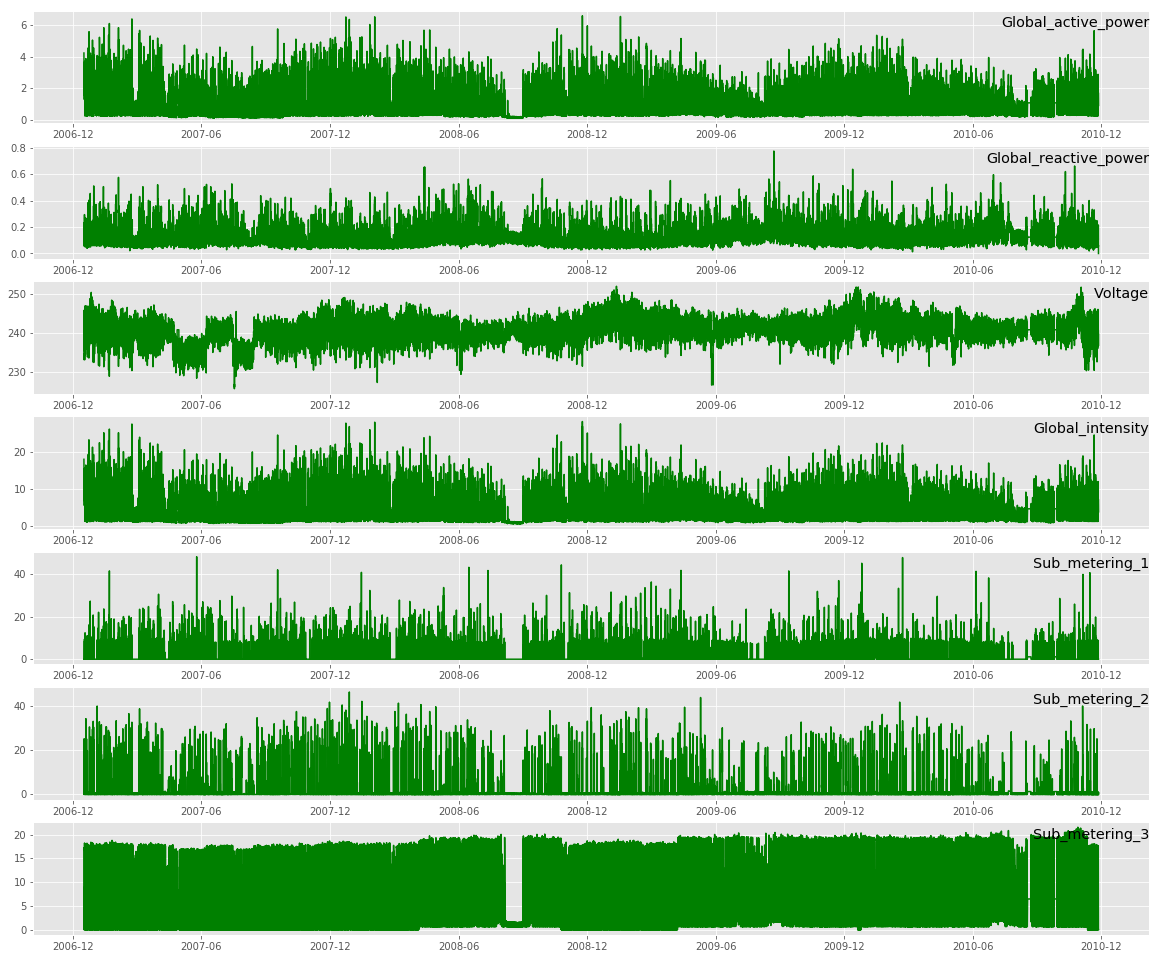

In [12]:
##plot resampled data by each feature
i=1
colnames=df_hour.columns
plt.figure(figsize=(20,17))
for names in colnames:
    plt.subplot(7,1,i)
    plt.plot(df_hour[names],'g')
    plt.title(names,y=0.8,loc='right')
    i += 1
plt.show()

In [13]:
df_hour.shape

(34589, 7)

<font color='red'>Note that the number of rows is reduced to 34589 from 207529 </font>

# Feature Engineering & Preprocessing

<font color='red'>I will use all features at the prior 1 timestep(t-1) to predict 'Global_active_power' at current timestep(t) </font>

In [14]:
# This function arranges the dataset to be used for surpervised learning by shifting the input values of features by the number
# time steps given in lag_steps
def create_dataset(data, lag_steps = 1, n_out = 1, dropnan = True):
    features = 1 if type(data) is list else data.shape[1] # Get the number of features in dataset
    df = pd.DataFrame(data)
    cols = list()
    feature_names = list()
     
    for i in range(lag_steps, 0, -1):
        cols.append(df.shift(i)) # This will be the shifted dataset
        feature_names += [(str(df.columns[j])) + '(t-%d)' % (i) for j in range(features)] # Names of the shifted features
     
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            feature_names += [(str(df.columns[j])) + '(t)' for j in range(features)]
        else:
            feature_names += [(str(df.columns[j])) + '(t+%d)' % (i) for j in range(features)] 
    agg = pd.concat(cols, axis=1) 
    agg.columns = feature_names
     
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [15]:
## create 'new' dataset 
new_df = create_dataset(df_hour).iloc[:,0:8]
new_df.head()

,Global_active_power(t-1),Global_reactive_power(t-1),Voltage(t-1),Global_intensity(t-1),Sub_metering_1(t-1),Sub_metering_2(t-1),Sub_metering_3(t-1),Global_active_power(t)
dt,,,,,,,,
2006-12-16 18:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111,3.632200
2006-12-16 19:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667,3.400233
2006-12-16 20:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333,3.268567
2006-12-16 21:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333,3.056467
2006-12-16 22:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667,2.200133


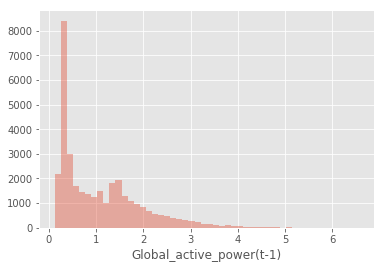

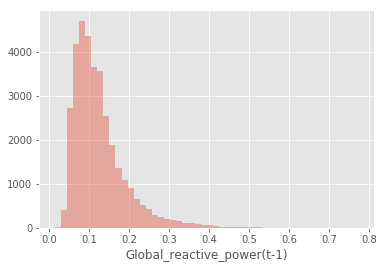

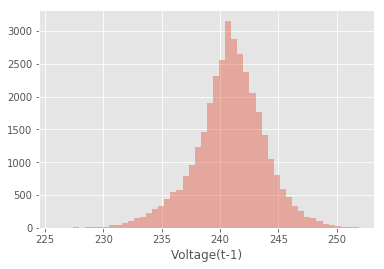

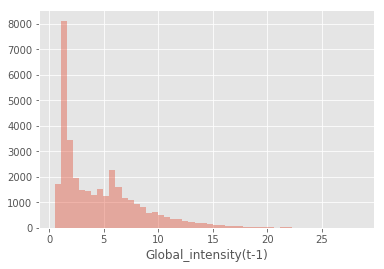

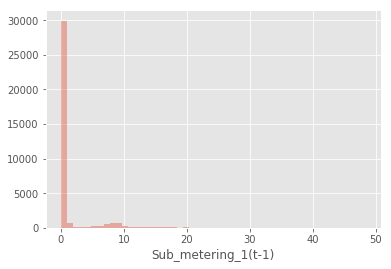

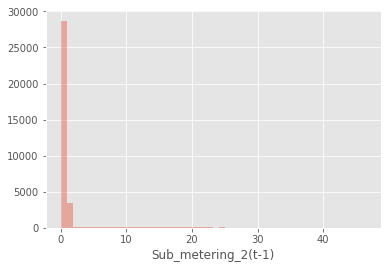

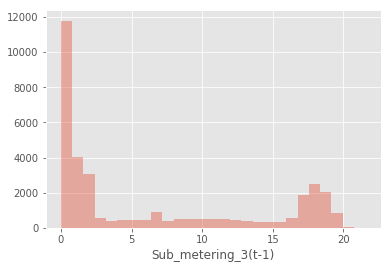

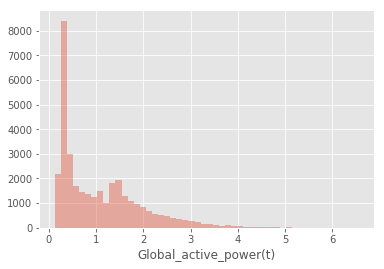

In [16]:
#check each feature distribution to determine if we need to normalize the data 
colnames=new_df.columns
for names in colnames:
    sns.distplot(new_df[names],kde=False)
    plt.show()

<font color='red'>Obviously, the ranges of the features are so different; if we try to apply distance based methods on these features, feature with the largest range will dominate the outcome results and we'll obtain less accurate predictions. We can address this problem by normalization.</font>

In [17]:
#scale all features in range of [0,1]
scaler = MinMaxScaler(feature_range=(0, 1))
scale = scaler.fit_transform(new_df)

In [18]:
scale_df=pd.DataFrame(scale,columns=new_df.columns)
scale_df.head()

,Global_active_power(t-1),Global_reactive_power(t-1),Voltage(t-1),Global_intensity(t-1),Sub_metering_1(t-1),Sub_metering_2(t-1),Sub_metering_3(t-1),Global_active_power(t)
0,0.636816,0.283776,0.337945,0.631157,0.0,0.011366,0.782418,0.545045
1,0.545045,0.088127,0.335501,0.541487,0.0,0.144652,0.782676,0.509006
2,0.509006,0.094957,0.283802,0.502152,0.0,0.030869,0.774169,0.488550
3,0.488550,0.081648,0.315987,0.481110,0.0,0.000000,0.778809,0.455597
4,0.455597,0.083705,0.434417,0.449904,0.0,0.008973,0.798917,0.322555


> Now we are ready to do some machine learning work!

# Start Modeling(LSTM)

In this showcase, I will use LSTM to give a time series prediction. 

## Splitting data into training set and test set

In [19]:
train_size = int(len(scale_df) * 0.67)
test_size = len(scale_df) - train_size
train, test = scale_df.iloc[0:train_size, :], scale_df.iloc[train_size:len(scale_df), :]

In [20]:
print(train.shape)
print(test.shape)

(23173, 8)
(11415, 8)


<font color='red'>We will train the model on the first 23173 rows of the data and test on the last 11415 rows of the data. </font>

In [21]:
# split into predictors and response
train_X, train_y = train.values[:, :-1], train.values[:, -1]
test_X, test_y = test.values[:, :-1], test.values[:, -1]

In [22]:
# reshape input to be 3-dimension [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)  

(23173, 1, 7) (23173,) (11415, 1, 7) (11415,)


In [23]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(train_X, train_y, epochs=10, batch_size=80,validation_data=(test_X, test_y),verbose=2)

Train on 23173 samples, validate on 11415 samples
Epoch 1/10
 - 2s - loss: 0.0128 - val_loss: 0.0080
Epoch 2/10
 - 1s - loss: 0.0097 - val_loss: 0.0079
Epoch 3/10
 - 1s - loss: 0.0096 - val_loss: 0.0078
Epoch 4/10
 - 1s - loss: 0.0095 - val_loss: 0.0077
Epoch 5/10
 - 1s - loss: 0.0095 - val_loss: 0.0078
Epoch 6/10
 - 1s - loss: 0.0095 - val_loss: 0.0077
Epoch 7/10
 - 1s - loss: 0.0095 - val_loss: 0.0077
Epoch 8/10
 - 1s - loss: 0.0094 - val_loss: 0.0078
Epoch 9/10
 - 1s - loss: 0.0094 - val_loss: 0.0078
Epoch 10/10
 - 1s - loss: 0.0094 - val_loss: 0.0078


In [24]:
# make a prediction
test_predict = model.predict(test_X)
train_predict = model.predict(train_X)
test_X = test_X.reshape((test_X.shape[0], 7))
train_X = train_X.reshape((train_X.shape[0], 7))

#invert scaling (training)
inv_train_pred = scaler.inverse_transform(np.concatenate((train_X,train_predict),axis=1))
inv_train_pred = inv_train_pred[:,inv_train_pred.shape[1]-1]

train_y = train_y.reshape((len(train_y), 1))
inv_train_actual= scaler.inverse_transform(np.concatenate((train_X,train_y), axis=1))
inv_train_actual = inv_train_actual[:,inv_train_actual.shape[1]-1]
# invert scaling (test)
inv_test_pred = scaler.inverse_transform(np.concatenate((test_X,test_predict),axis=1))
inv_test_pred = inv_test_pred[:,inv_test_pred.shape[1]-1]

test_y = test_y.reshape((len(test_y), 1))
inv_test_actual= scaler.inverse_transform(np.concatenate((test_X,test_y), axis=1))
inv_test_actual = inv_test_actual[:,inv_test_actual.shape[1]-1]

In [25]:
rmse_train = np.sqrt(mean_squared_error(inv_train_actual, inv_train_pred))
rmse_test = np.sqrt(mean_squared_error(inv_test_actual, inv_test_pred))
print('Training RMSE: %.4f' % rmse_train)
print('Test RMSE: %.4f' % rmse_test)

Training RMSE: 0.6239
Test RMSE: 0.5683


Text(0.5,1,'Test Result')

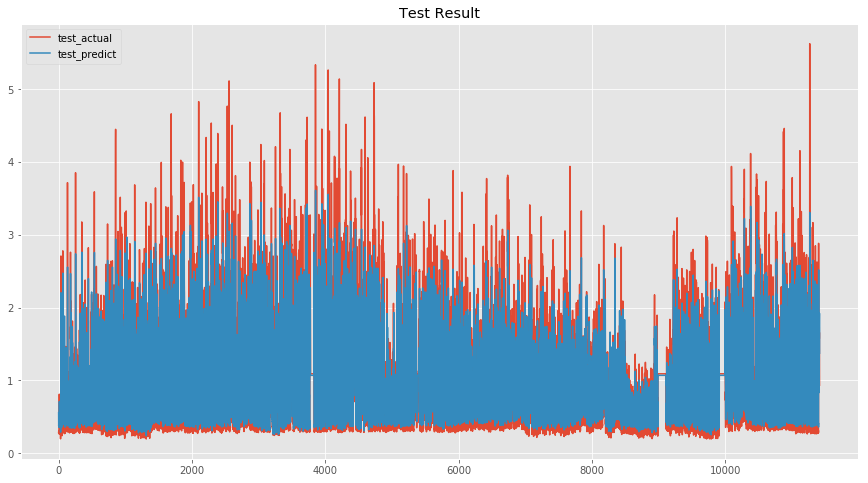

In [26]:
plt.figure(figsize=(15,8))
plt.plot(inv_test_actual)
plt.plot(inv_test_pred)
plt.legend(['test_actual', 'test_predict'], loc='upper left')
plt.title('Test Result')

# Conclusion

1. I used LSTM with below specification to give predictions:  
   a. 100 neurons in the input layer   
   b. 1 neuron in the output layer  
   c. used MSE as loss function and Adam as optimizer   
   d. 10 epoches with batch size of 80 
  
2. The above model is just a preliminary investigation, the result can be further improved.    
3. Note that I reduced a large number of observation while performing resampling. If we have large dataset, for the sake of computation time， we should train our model on GPU. 